In [1]:
import os
import re
import numpy as np
import robosuite
import sys
import os
import scipy 


sys.path.append(os.path.abspath("/Users/jeremiahetiosaomeike/Desktop/Research_Projs/vla/LIBERO"))

from robosuite.models.objects import MujocoXMLObject
from robosuite.utils.mjcf_utils import xml_path_completion

from libero.libero.envs.base_object import register_object

import pathlib

from libero.libero.envs.base_object import (
    register_visual_change_object,
    register_object,
)
from libero.libero.utils.mu_utils import register_mu, InitialSceneTemplates
from libero.libero.utils.task_generation_utils import register_task_info, get_task_info, generate_bddl_from_task_info


[robosuite WARNING] No private macro file found! (__init__.py:7)
[robosuite WARNING] It is recommended to use a private macro file (__init__.py:8)
[robosuite WARNING] To setup, run: python /Users/jeremiahetiosaomeike/Desktop/Research_Projs/vla/LIBERO/libero_venv/lib/python3.10/site-packages/robosuite/scripts/setup_macros.py (__init__.py:9)


## Define your own objects
You may want to include more object meshes of yours in the procedural generation pipeline. One option is to include your assets and define your object directly inside the LIBERO codebase. But this can make the whole thing messy. 

Alternatively, you can define the objects inside your custom project repo folder, and define the object classes accordingly. Note that you need to import your defined object classes whenever you run your own stuff. Libero codebase cannot automatically import those that are defined outside its repo.

In the next, we provide an example, assuming you have object meses defined in `custom_assets`. In this example, we assume the generated pddl file will be saved in `custom_pddl`.

In [2]:

class CustomObjects(MujocoXMLObject):
    def __init__(self, custom_path, name, obj_name, joints=[dict(type="free", damping="0.0005")]):
        # make sure custom path is an absolute path
        assert(os.path.isabs(custom_path)), "Custom path must be an absolute path"
        # make sure the custom path is also an xml file
        assert(custom_path.endswith(".xml")), "Custom path must be an xml file"
        super().__init__(
            custom_path,
            name=name,
            joints=joints,
            obj_type="all",
            duplicate_collision_geoms=False,
        )
        self.category_name = "_".join(
            re.sub(r"([A-Z])", r" \1", self.__class__.__name__).split()
        ).lower()
        self.object_properties = {"vis_site_names": {}}

@register_object
class LiberoMug(CustomObjects):
    def __init__(self,
                 name="libero_mug",
                 obj_name="libero_mug",
                 ):
        super().__init__(
            custom_path=os.path.abspath(os.path.join(
                "./", "custom_assets", "libero_mug", "libero_mug.xml"
            )),
            name=name,
            obj_name=obj_name,
        )

        self.rotation = {
            "x": (-np.pi/2, -np.pi/2),
            "y": (-np.pi, -np.pi),
            "z": (np.pi, np.pi),
        }
        self.rotation_axis = None

@register_object
class LiberoMugYellow(CustomObjects):
    def __init__(self,
                 name="libero_mug",
                 obj_name="libero_mug",
                 ):
        super().__init__(
            custom_path=os.path.abspath(os.path.join(
                "./", "custom_assets", "libero_mug_yellow", "libero_mug_yellow.xml"
            )),
            name=name,
            obj_name=obj_name,
        )

        self.rotation = {
            "x": (-np.pi/2, -np.pi/2),
            "y": (-np.pi, -np.pi),
            "z": (np.pi, np.pi),
        }
        self.rotation_axis = None


### Define the scene
Now we define the scene to load the previously defined objects. For more information about the scene genration, please look at `procedural_creation_walkthrough.ipynb`. 

In [3]:
import re
from libero.libero.envs import objects
from libero.libero.utils.bddl_generation_utils import *
from libero.libero.envs.objects import OBJECTS_DICT
from libero.libero.utils.object_utils import get_affordance_regions

from libero.libero.utils.mu_utils import register_mu, InitialSceneTemplates

@register_mu(scene_type="kitchen")
class KitchenDemoScene(InitialSceneTemplates):
    def __init__(self):

        fixture_num_info = {
            "kitchen_table": 1,
            "wooden_cabinet": 1,
        }

        object_num_info = {
            "libero_mug": 1,
            "libero_mug_yellow": 1,
        }

        super().__init__(
            workspace_name="kitchen_table",
            fixture_num_info=fixture_num_info,
            object_num_info=object_num_info,
        )

    def define_regions(self):
        self.regions.update(
            self.get_region_dict(
                region_centroid_xy=[0.0, -0.30],
                region_name="wooden_cabinet_init_region",
                target_name=self.workspace_name,
                region_half_len=0.01,
                yaw_rotation=(np.pi, np.pi),
            )
        )

        self.regions.update(
            self.get_region_dict(
                region_centroid_xy=[0.0, 0.0],
                region_name="libero_mug_init_region",
                target_name=self.workspace_name,
                region_half_len=0.025,
            )
        )

        self.regions.update(
            self.get_region_dict(
                region_centroid_xy=[-0.1, 0.15],
                region_name="libero_mug_yellow_init_region",
                target_name=self.workspace_name,
                region_half_len=0.025,
            )
        )
        self.xy_region_kwargs_list = get_xy_region_kwargs_list_from_regions_info(
            self.regions
        )

    @property
    def init_states(self):
        states = [
            ("On", "libero_mug_1", "kitchen_table_libero_mug_init_region"),
            ("On", "libero_mug_yellow_1", "kitchen_table_libero_mug_yellow_init_region"),
            ("On", "wooden_cabinet_1", "kitchen_table_wooden_cabinet_init_region"),
        ]
        return states

Succefully generated: 1
['./custom_pddl/KITCHEN_DEMO_SCENE_libero_demo_behaviors.bddl']
Encountered some failures:  []
(define (problem LIBERO_Kitchen_Tabletop_Manipulation)
  (:domain robosuite)
  (:language libero demo behaviors)
    (:regions
      (wooden_cabinet_init_region
          (:target kitchen_table)
          (:ranges (
              (-0.01 -0.31 0.01 -0.29)
            )
          )
          (:yaw_rotation (
              (3.141592653589793 3.141592653589793)
            )
          )
      )
      (libero_mug_init_region
          (:target kitchen_table)
          (:ranges (
              (-0.025 -0.025 0.025 0.025)
            )
          )
          (:yaw_rotation (
              (0.0 0.0)
            )
          )
      )
      (libero_mug_yellow_init_region
          (:target kitchen_table)
          (:ranges (
              (-0.125 0.125 -0.07500000000000001 0.175)
            )
          )
          (:yaw_rotation (
              (0.0 0.0)
            )
          

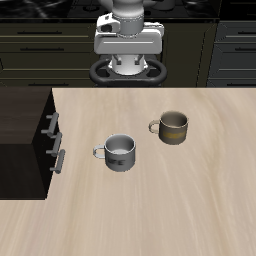

In [4]:
scene_name = "kitchen_demo_scene"
language = "libero demo behaviors"
register_task_info(language,
                   scene_name=scene_name,
                   objects_of_interest=[],
                   goal_states=[
                       ("Open", "wooden_cabinet_1_top_region"),
                       ("In", "libero_mug_yellow_1", "wooden_cabinet_1_top_region"),
                       ],
)

YOUR_BDDL_FILE_PATH = "./custom_pddl"
bddl_file_names, failures = generate_bddl_from_task_info(folder=YOUR_BDDL_FILE_PATH)
print(bddl_file_names)

print("Encountered some failures: ", failures)

with open(bddl_file_names[0], "r") as f:
    print(f.read())

from libero.libero.envs import OffScreenRenderEnv
from IPython.display import display
from PIL import Image

import torch
import torchvision


env_args = {
    "bddl_file_name": bddl_file_names[0],
    "camera_heights": 256,
    "camera_widths": 256
}

env = OffScreenRenderEnv(**env_args)
obs = env.reset()
display(Image.fromarray(obs["agentview_image"][::-1]))

In [7]:
from transformers import AutoModelForVision2Seq, AutoProcessor

import torch

# Load Processor & VLA
processor = AutoProcessor.from_pretrained("openvla/openvla-7b", trust_remote_code=True)
vla = AutoModelForVision2Seq.from_pretrained(
    "openvla/openvla-7b", 
    # attn_implementation="flash_attention_2",  # [Optional] Requires `flash_attn`
    torch_dtype=torch.bfloat16, 
    # low_cpu_mem_usage=True, 
    trust_remote_code=True
)

# Grab image input & format prompt
image: Image.Image = Image.fromarray(obs["agentview_image"][::-1])
prompt = "In: What action should the robot take to put the gray cup on the dark brown cabinet?\nOut:"

# Predict Action (7-DoF; un-normalize for BridgeData V2)
inputs = processor(prompt, image).to(dtype=torch.bfloat16)
action = vla.predict_action(**inputs, unnorm_key="bridge_orig", do_sample=False)
print(action)

Expected `transformers==4.40.1` and `tokenizers==0.19.1` but got `transformers==4.36.0` and `tokenizers==0.15.2`; there might be inference-time regressions due to dependency changes. If in doubt, pleaseuse the above versions.
Loading checkpoint shards: 100%|██████████| 3/3 [00:15<00:00,  5.13s/it]


[-2.86154160e-02  1.84219623e-03  1.85814697e-05 -5.88622887e-03
  4.07510140e-02 -3.55262690e-02  9.96078431e-01]


In [15]:
outputs = vla(**inputs, output_hidden_states=True)


In [19]:
last_hidden_state = outputs.hidden_states[-1]
print("Last hidden state shape:", last_hidden_state.shape)


Last hidden state shape: torch.Size([1, 279, 4096])


In [13]:
def normalize_gripper_action(action, binarize=True):
    """
    Changes gripper action (last dimension of action vector) from [0,1] to [-1,+1].
    Necessary for some environments (not Bridge) because the dataset wrapper standardizes gripper actions to [0,1].
    Note that unlike the other action dimensions, the gripper action is not normalized to [-1,+1] by default by
    the dataset wrapper.

    Normalization formula: y = 2 * (x - orig_low) / (orig_high - orig_low) - 1
    """
    # Just normalize the last action to [-1,+1].
    orig_low, orig_high = 0.0, 1.0
    action[..., -1] = 2 * (action[..., -1] - orig_low) / (orig_high - orig_low) - 1

    if binarize:
        # Binarize to -1 or +1.
        action[..., -1] = np.sign(action[..., -1])

    return action

def invert_gripper_action(action):
    """
    Flips the sign of the gripper action (last dimension of action vector).
    This is necessary for some environments where -1 = open, +1 = close, since
    the RLDS dataloader aligns gripper actions such that 0 = close, 1 = open.
    """
    action[..., -1] = action[..., -1] * -1.0
    return action

action = normalize_gripper_action(action, binarize=True)
action = invert_gripper_action(action)

binary entropy probe

In [ ]:
import json
import os
import pickle
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy
import torch
import wandb
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
# Bootstrapping methods from ../semantic_entropy/uncertainty/utils/eval_utils.py
def bootstrap_func(y_true, y_score, func):
    y_tuple = (y_true, y_score)
    
    metric_i = func(*y_tuple)
    metric_dict = {}
    metric_dict['mean'] = metric_i
    metric_dict['bootstrap'] = compatible_bootstrap(
        func, rng)(*y_tuple)  # a bit slow to run

    return metric_dict

def bootstrap(function, rng, n_resamples=1000):
    def inner(data):
        bs = scipy.stats.bootstrap(
            (data, ), function, n_resamples=n_resamples, confidence_level=0.9,
            random_state=rng)
        return {
            'std_err': bs.standard_error,
            'low': bs.confidence_interval.low,
            'high': bs.confidence_interval.high
        }
    return inner

def auroc(y_true, y_score):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    del thresholds
    return metrics.auc(fpr, tpr)

def compatible_bootstrap(func, rng):
    def helper(y_true_y_score):
        # this function is called in the bootstrap
        y_true = np.array([i['y_true'] for i in y_true_y_score])
        y_score = np.array([i['y_score'] for i in y_true_y_score])
        out = func(y_true, y_score)
        return out

    def wrap_inputs(y_true, y_score):
        return [{'y_true': i, 'y_score': j} for i, j in zip(y_true, y_score)]

    def converted_func(y_true, y_score):
        y_true_y_score = wrap_inputs(y_true, y_score)
        return bootstrap(helper, rng=rng)(y_true_y_score)
    return converted_func

In [ ]:
# Train and evaluation function.
def sklearn_train_and_evaluate(model, X_train, y_train, X_valid, y_valid, silent=False):
    model.fit(X_train, y_train)
    
    # Calculate training loss and score
    train_probs = model.predict_proba(X_train)
    train_loss = log_loss(y_train, train_probs)

    # Calculate validation loss
    valid_preds = model.predict(X_valid)
    valid_probs = model.predict_proba(X_valid)
    valid_loss = log_loss(y_valid, valid_probs)
    val_accuracy = np.mean((valid_preds == y_valid).astype(int))
    auroc_score = roc_auc_score(y_valid, valid_probs[:,1])
    if not silent:
        print(f"Validation Accuracy: {val_accuracy:.4f}, AUROC: {auroc_score:.4f}")
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

def sklearn_evaluate_on_test(model, X_test, y_test, silent=False, bootstrap=True):
    test_preds = model.predict(X_test)
    test_probs = model.predict_proba(X_test)
    test_loss = log_loss(y_test, test_probs)
    test_accuracy = np.mean((test_preds == y_test).astype(int))
    
    if bootstrap:
        auroc_score = bootstrap_func(y_test, test_probs[:,1], auroc)
        auroc_score_scalar = auroc_score['mean']
    else:
        auroc_score = auroc_score_scalar = roc_auc_score(y_test, test_probs[:, 1])
    
    if not silent:
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, AUROC: {auroc_score_scalar:.4f}")
    
    return test_loss, test_accuracy, auroc_score

def train_single_metric(D, token_type='tbg', metric='b_entropy'):
    """train and test on single metric (e.g. SE, Acc) on single dataset"""
    var_name = token_type[0] + metric[0] 
    # named as [te, se. ta, sa] for easy identification; t for tbg, s for slt (token positions)
    # e for entropy and a for accuracy (or model faithfulness)
    X_trains, X_vals, X_tests, y_trains, y_vals, y_tests = create_Xs_and_ys(
        getattr(D, f'{token_type}_dataset'), getattr(D, metric)
    )

    accs = []
    aucs = []
    models = []
    
    for i, (X_train, X_val, X_test, y_train, y_val, y_test) in enumerate(zip(X_trains, X_vals, X_tests, y_trains, y_vals, y_tests)):
        print(f"Training on {D.name}-{token_type.upper()}-{metric.upper()} {i+1}/{len(X_trains)}")
        model = LogisticRegression()
        sklearn_train_and_evaluate(model, X_train, y_train, X_val, y_val)
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test, y_test)
        accs.append(test_acc)
        aucs.append(test_auc)
        models.append(model)

    setattr(D, f'{var_name}_accs', accs)
    setattr(D, f'{var_name}_aucs', aucs)
    setattr(D, f'{var_name}_models', models)

# simple get-around for unpacking bootstrapping dicts
auc = lambda aucs : [ac['mean'] for ac in aucs] 
idf = lambda x : x  # identical function

In [ ]:
# Best split for SE binarization.
def best_split(entropy: torch.Tensor, label="Dx"):
    """
    Identify best split for minimizing reconstruction error via low and high SE mean estimates,
    as discussed in Section 4. Binarization of paper (ArXiv: 2406.15927)
    """
    ents = entropy.numpy()
    splits = np.linspace(1e-10, ents.max(), 100)
    split_mses = []
    for split in splits:
        low_idxs, high_idxs = ents < split, ents >= split
    
        low_mean = np.mean(ents[low_idxs])
        high_mean = np.mean(ents[high_idxs])
    
        mse = np.sum((ents[low_idxs] - low_mean)**2) + np.sum((ents[high_idxs] - high_mean)**2)
        mse = np.sum(mse)
    
        split_mses.append(mse)
    
    split_mses = np.array(split_mses)
    
    plt.plot(splits, split_mses, label=label)
    return splits[np.argmin(split_mses)]

def binarize_entropy(entropy, thres=0.0):  # 0.0 means even splits for normalized entropy scores
    """Binarize entropy scores into 0s and 1s"""
    binary_entropy = torch.full_like(entropy, -1, dtype=torch.float)
    binary_entropy[entropy < thres] = 0
    binary_entropy[entropy > thres] = 1

    return binary_entropy

In [ ]:
# Best universal split across datasets
split_method = 'best-universal-split'
all_entropy = torch.cat([D.entropy for D in Ds], dim=0)
split = best_split(all_entropy, "All datasets collective")
plt.legend()
plt.title('Sum of squared errors at different splits')
for D in Ds:
    D.b_entropy = binarize_entropy(D.entropy, split)
    print(f"Dummy accuracy for {D.name}: {max(torch.mean(D.b_entropy).item(), 1-torch.mean(D.b_entropy).item()):.4f}")

In [ ]:
for D in Ds:
    train_single_metric(D, 'tbg', 'b_entropy')
    train_single_metric(D, 'slt', 'b_entropy')

In [ ]:
# plot se probe
fig, axs = plt.subplots(1, len(Ds), figsize=(5 * len(Ds), 4.5))
for i, D in enumerate(Ds):
    plot_metrics_ax(axs[i], [auc(D.tb_aucs), auc(D.sb_aucs)], ["SE Probe on TBG token", "SE Probe on SLT token"], 
                    f"AUROC on {D.name.upper()}", prep_func=idf)
plt.tight_layout()
save_fig(name="se_both_tok")
plt.show()